## Prepare dataset

In [1]:
!cat ./dataset/datasets.py

import torch
from torch.utils.data import Dataset
from collections import OrderedDict


class CustomDataset(Dataset):
    def __init__(self, df, numerical_columns, categorical_columns, target):
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.X = df[numerical_columns+categorical_columns]
        self.y = df[target]

        self.num_unique_values_dict = {}
        for col in self.categorical_columns:
            self.num_unique_values_dict[col] = len(self.X[col].unique())

    def __len__(self):
        return len(self.X)

    def __getitem__(self, indx):
        row = self.X.iloc[indx, :]
        numerical_values = row[self.numerical_columns].values
        category_values = OrderedDict({col: torch.tensor(row[col], dtype=torch.long)
                                       for col in self.categorical_columns})
        target = self.y[indx]
        return category_values, numerical_values, target


## Prepare model's layers

In [2]:
!cat ./model/layers.py

import torch
import torch.nn as nn
import torch.nn.functional as f
from model.utils import GBN, split, Sparsemax


class DenseFeatureLayer(nn.Module):
    def __init__(self, num_unique_values_dict: dict, embedding_size: int, n_numerical_columns: int):
        super(DenseFeatureLayer, self).__init__()
        self.num_unique_values_dict = num_unique_values_dict
        self.embedding_size = embedding_size

        self.embedding_layers = nn.ModuleDict({col: nn.Embedding(num, self.embedding_size) for col, num in
                                               self.num_unique_values_dict.items()})
        self.output_shape = len(self.num_unique_values_dict) * embedding_size + n_numerical_columns
        self.batch_norm = nn.BatchNorm1d(self.output_shape)

    def forward(self, categorical, numerical):
        x_cat = [self.embedding_layers[col](number) for col, number in categorical.items()]
        x_cat = torch.cat(x_cat, dim=-1)
        features = torch.cat((x_cat, numerical), dim=-1).f

## Prepare base class for Tabnet

In [3]:
!cat ./model/tabnet.py

import torch
import torch.nn as nn

from model.layers import DenseFeatureLayer, FeatureTransformer, SharedTransformerBlock, DecisionStepBlock
from model.utils import split


class TabNet(nn.Module):
    def __init__(self,
                 num_unique_values_dict: dict,
                 embedding_size: int,
                 n_numerical_columns: int,
                 n_shared_layers: int,
                 n_decision_blocks: int,
                 hidden_size: int,
                 meaningful_part: float,
                 n_decision_steps: int,
                 virtual_batch_size: int,
                 momentum: float,
                 gamma: float
                 ):

        super(TabNet, self).__init__()

        self.num_unique_values_dict = num_unique_values_dict
        self.embedding_size = embedding_size
        self.n_numerical_columns = n_numerical_columns
        self.n_shared_layers = n_shared_layers
        self.n_decision_blocks = n_decision_blocks
        self.hidden_size = h

## Prepare tabnet classifier

In [4]:
!cat ./model/classification_network.py

import torch.nn as nn
from model.tabnet import TabNet


class ClassificationBlock(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super(ClassificationBlock, self).__init__()

        self.fc = nn.Linear(input_size, output_size)
        self.batch_norm = nn.BatchNorm1d(num_features=output_size)

    def forward(self, batch):
        x = self.fc(batch)
        x = self.batch_norm(x)
        return x


class TabNetClassifier(nn.Module):
    def __init__(self, n_output_classes: int,
                 n_classification_layer: int,
                 num_unique_values_dict: dict,
                 embedding_size: int,
                 n_numerical_columns: int,
                 n_shared_layers: int,
                 n_decision_blocks: int,
                 hidden_size: int,
                 meaningful_part: float,
                 n_decision_steps: int,
                 virtual_batch_size: int,
                 momentum: float,
                 gamma: float
         

## Auxiliary train loops

In [5]:
!cat ./train_aux.py

import torch
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import mlflow
from torch.utils.tensorboard import SummaryWriter


def train_epoch(cfg, model, dataloader,  clf_criterion, sparce_criterion, optimizer):
    train_loss = 0
    train_clf_loss = 0
    train_sparce_loss = 0
    correct_train = 0
    size = 0

    model.train()
    for X_cat, X_num, y_batch in dataloader:
        x_batch = [X_cat, X_num]
        optimizer.zero_grad()
        output, masks = model(x_batch)

        if cfg.n_output_classes == 1:
            y_float = y_batch.reshape(-1, 1).float()
            clf_loss = clf_criterion(output, y_float)
            predict = (torch.sigmoid(output).detach().numpy() > 0.5).astype(int).ravel()
        else:
            clf_loss = clf_criterion(output, y_batch)
            predict = np.argmax(torch.softmax(output, dim=-1).detach().numpy(), axis=-1)

        sparce_loss = sparce_criterion(masks)
        loss = clf_loss + cfg.lambda_sparce * 

Model parameters is logged using mlflow and tensorboard. 
* Mlflow is used for logging config, parameters of model and learning curves.
* Tensorboard logging is used to log learning curves in and display it in real time.

## Train model

In [6]:
!cat ./train.py

# Other libs
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from omegaconf import DictConfig
import random
import numpy as np

# MLflow
import mlflow
from mlflow.exceptions import MlflowException
from mlflow.tracking import MlflowClient

# Hydra
import hydra
from hydra import utils

# Pytorch
import torch
import torch.nn as nn

# Custom files
from dataset.datasets import CustomDataset
from model.classification_network import TabNetClassifier
from model.sparce_loss import SparceLoss
from train_aux import train_model


DATA_PATH = os.path.join(os.path.abspath("."), "data/encoded_dataset.csv")


def load_data(data_path: str, seed: int, test_size: float = 0.2):
    df = pd.read_csv(data_path)
    data_train, data_valid = train_test_split(df, test_size=test_size, stratify=df['salary'], shuffle=True,
                                              random_state=seed)
    data_train.reset_index(drop=True, inplace=True)
    data_valid.reset_index(drop=True, inp

## Run training 

Training use hydra configs to configure model and parameters of learning. More parameters available in configs folder.

Hydra creates own config in own folder for each run. There is main config, overrides and hydra config. Also I made tensorboard logging in to the same folder as each hydra run. Mlflow loging happens in mlflow main folder.

Run example:

* ```python train.py```

With sheduler enable:
* ```python train.py scheduler.enable=True```

With different learning rate:
* ```python train.py learning_rate=3e-4```

With different optimizer:
* ```python train.py optimizer=SGD```

Multi-run:
* ```python train.py -m n_decision_steps=5,2 batch_size=512,4096 ```

## Some result of run

the experiment results were obtained by the following command:
* ```python train.py -m scheduler.enable=True n_decision_steps=5,2 batch_size=4096,512 run_name="multi_run"```
* ```python train.py -m scheduler.enable=True n_decision_steps=2 batch_size=4096,512 run_name="multi_run" learning_rate=0.001,3e-4```
* ```python train.py -m scheduler.enable=True n_decision_steps=2 batch_size=512 run_name="multi_run_batch_norm" learning_rate=0.001,3e-4 virtual_batch_size=512```

Best result is shown below:

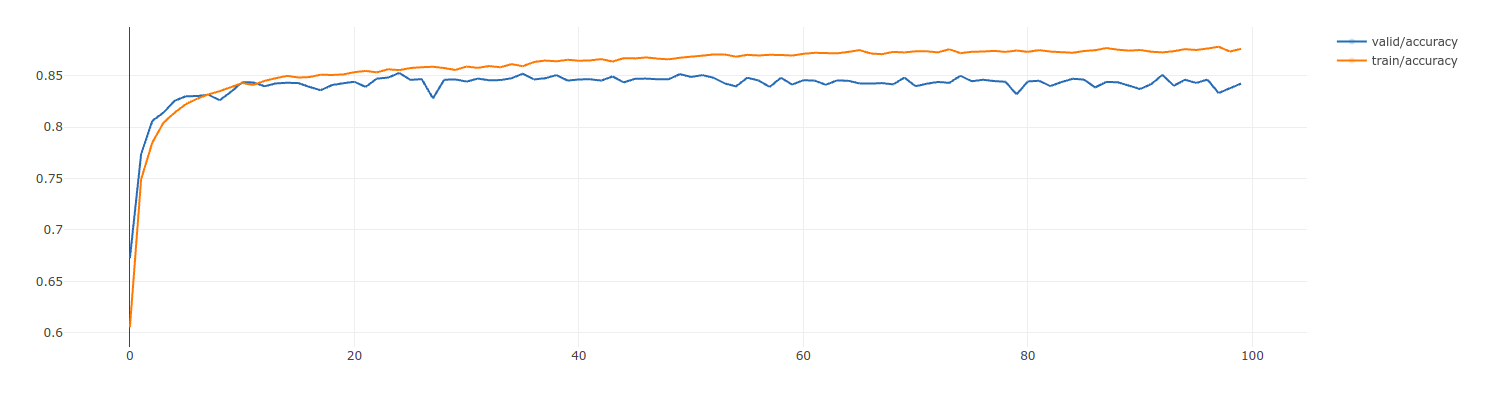

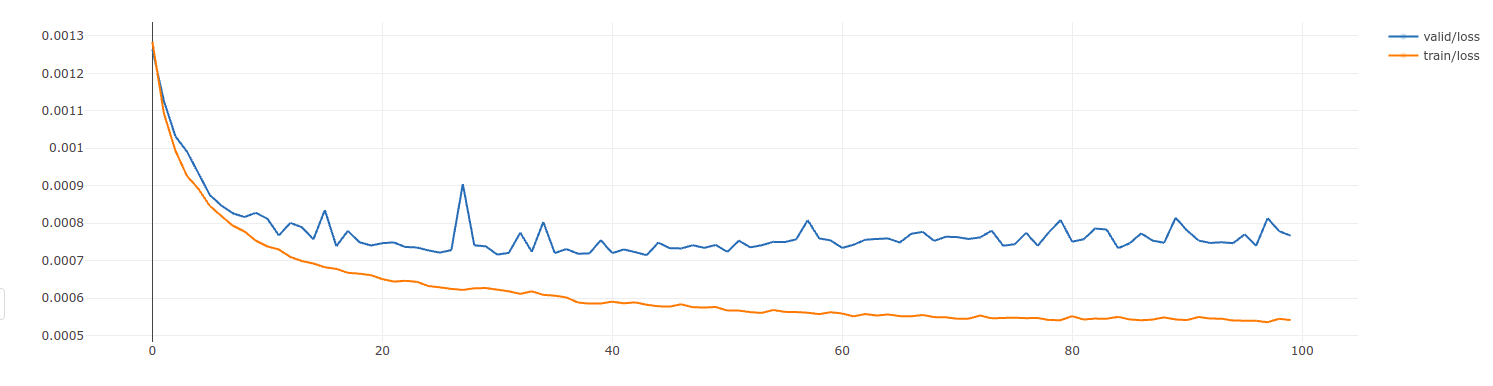